<h1>Create a machine learning model to trade cryptocurrency</h1>


<p>In this jupyter notebook, I want to create a bot that can make money from the cryptocurrency market</p>
<p>Common methods for forecasting financial markets are usually time series methods such as ARIMA, etc., but I want to solve this problem with a new approach.
In this jupyter notebook, I use classification models to solve this challenge.</p>


<h3>>>> Importing necessary modules </h3>

In [78]:
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score

<h3>>>> Collect data from binance API</h3>

<p>We used the ccxt module to get the data.</p>
<p>For more information about this powerful module, you can use the following link. <a href="https://github.com/ccxt/ccxt"> CCXT – CryptoCurrency eXchange Trading Library
</a></p>


<p>We collect all daily ETH USDT data from the Binance broker.</p>
<p>This information consists of 5 columns which are date, open, high, low, close and volume.</p>
<ul>
    <li>date: The time of opening the candle</li>
    <li>open: The first price traded</li>
    <li>high: The highest price traded</li>
    <li>low: The lowest price traded</li>
    <li>close: Last traded price</li>
    <li>volume: traded volume</li>
</ul>


In [79]:
# """ import all ETHUSDT OHLC data from Binance """
coin='ETH/USDT'
timeframe='1d'
exchange=ccxt.binance()
start_date=0
# start_date = int(datetime.datetime(2017, 1, 1, 1, 1).timestamp() * 1000)

data=pd.DataFrame(columns=['date', 'open', 'high', 'low', 'close', 'volume'])

while True:
    response=exchange.fetch_ohlcv(coin, timeframe, since=start_date, limit=1000)
    df=pd.DataFrame(response, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    updateData=pd.merge(data, df, how='outer')
    if len(data)!=len(updateData):
        data=updateData.copy()
        start_date=data['date'].iloc[-1]
    else:
        break
    
data.drop_duplicates(inplace=True,subset=['date'])
data.date=pd.to_datetime(data['date'], unit='ms', utc=True, yearfirst=True)
data.drop(data.tail(1).index,inplace=True) # because the last row is not close
data.to_csv('data.csv')
print(data.head(5))
print(data.tail(5))

                       date    open    high     low   close      volume
0 2017-08-17 00:00:00+00:00  301.13  312.18  298.00  302.00  7030.71034
1 2017-08-18 00:00:00+00:00  302.00  311.79  283.94  293.96  9537.84646
2 2017-08-19 00:00:00+00:00  293.31  299.90  278.00  290.91  2146.19773
3 2017-08-20 00:00:00+00:00  289.41  300.53  282.85  299.10  2510.13871
4 2017-08-21 00:00:00+00:00  299.10  346.52  294.60  323.29  5219.44542
                          date     open     high      low    close  \
1697 2022-04-10 00:00:00+00:00  3258.57  3307.22  3193.00  3203.04   
1698 2022-04-11 00:00:00+00:00  3203.04  3213.63  2950.00  2979.74   
1699 2022-04-12 00:00:00+00:00  2979.75  3085.00  2950.00  3027.66   
1700 2022-04-13 00:00:00+00:00  3027.65  3128.97  2996.86  3118.28   
1701 2022-04-14 00:00:00+00:00  3118.28  3145.00  2976.30  3021.98   

           volume  
1697  232303.2326  
1698  693394.2912  
1699  579522.9505  
1700  419101.4940  
1701  408382.5572  


<h3>>>> Create independent variable</h3>

<h4>DrawDown</h4>
<p>To use the machine learning model, we need more predictive variables.
One of the variables we can use is drawdown.</p>
<p>A drawdown is a peak-to-trough decline during a specific period for an investment, trading account, or fund. A drawdown is usually quoted as the percentage between the peak and the subsequent trough. If a trading account has $10,000 in it, and the funds drop to $9,000 before moving back above $10,000, then the trading account witnessed a 10% drawdown.</p>


In [80]:
# Calculate drawdown
HighestHigh = [data['high'].iloc[0]]
for i in range(1,len(data)):
    if data['high'].iloc[i] >= HighestHigh[-1]:
        HighestHigh.append(data['high'].iloc[i])
    else:
        HighestHigh.append(HighestHigh[-1])
        
data['HighestHigh'] = HighestHigh
data['DrawDown'] = data.apply(lambda row: 0 if row['high']==row['HighestHigh'] else (row['low']-row['HighestHigh'])*100/row['HighestHigh'], axis=1)



<h4>Maximum drawdown(MDD)</h4>
<p>Maximum drawdown is a specific measure of drawdown that looks for the greatest movement from a high point to a low point, before a new peak is achieved.<p>

In [81]:
# Maximum Drawdown (MDD) 
print("Maximum Drawdown (MDD): {0} %".format(data.loc[data['DrawDown'] == min(data['DrawDown']) ,"DrawDown"].values[0].round(2)))  

Maximum Drawdown (MDD): -94.32 %


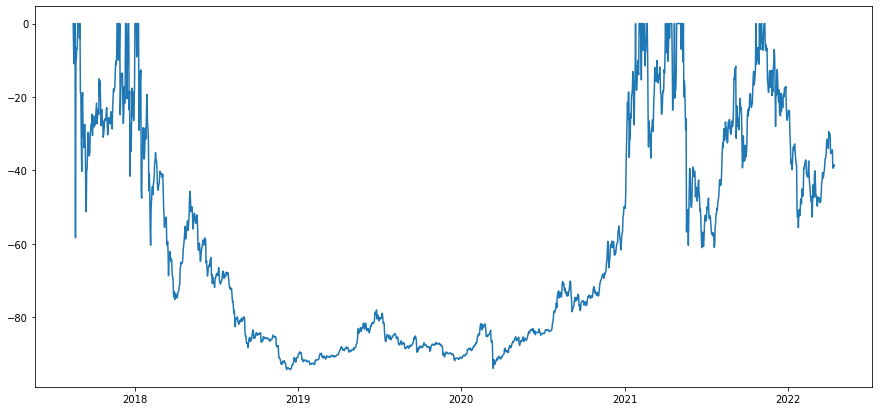

In [82]:
# plot drawdown
plt.figure(figsize=(15,7))
plt.plot(data['date'], data['DrawDown'])

In [83]:
# add important variables

for i in range(1,51):
    data['pctchange{0}'.format(i)]=data['close'].pct_change(i)

for i in range(1,51):
    data['pctchange1_{0}'.format(i)] = data['pctchange1'].shift(i)
    data['DrawDown{0}'.format(i)] = data['DrawDown'].shift(i)

data['year']=data['date'].dt.year
data['month']=data['date'].dt.month
data['day']=data['date'].dt.day
data['dayofyear']=data['date'].dt.dayofyear

data.dropna(inplace=True)

<h3>>>> Defining dependent variable</h3>
<p>Here we define our dependent variable as follows:
If the next candle has a price increase of more than 1%, we will enter the buying position.
We can use any amount more from the exchange commission because of that way we make a profit.</p>
<p>with this trick, we can now use classification models :)</p>

In [84]:
data['target']=data['pctchange1'].apply(lambda x : 1 if x>0.01 else 0)

<h3>>>> Split the dataset into a training dataset and a test dataset</h3>
<p>The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.</p>

In [85]:
# we subset our data frame to 
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.difference(['date','pctchange1','target'])], data['target'], test_size=0.33, random_state=42)

<h3>>>> Create XGboost model</h3>

In [86]:
xg_reg = xgb.XGBClassifier(num_class=1,
                            learning_rate=0.1,
                            max_depth=10,
                            scale_pos_weight=1.5,
                            eval_metric='mlogloss',
                            use_label_encoder=False)
xg_reg.fit( X_train, y_train )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_class=1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.5,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

<h3>>>> Top 10 most important features</h3>

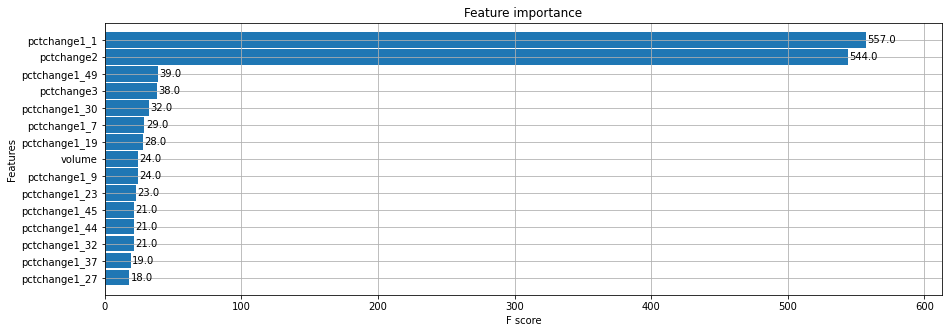

In [87]:
ax= plot_importance( xg_reg , height=0.9, max_num_features=15)
fig = ax.figure
fig.set_size_inches(15, 5)


<p><i>We found that the drawdown variable did not have much effect on predicting our dependent variable and we could remove it from the model training process in the future.</i><p>

<h3>>>> K-fold Cross Validation</h3>
<p>Cross-validation is a statistical method used to estimate the skill of machine learning models.</p>
<p>For more information about k-fold cross validation, you can use the following link. <a href="https://machinelearningmastery.com/k-fold-cross-validation/">K-fold Cross Validation</a></p>



<img alt="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" class="align-center" src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" style="width: 500px; height: 300px;">


In [88]:
accuracies = cross_val_score(estimator=xg_reg, X=X_train, y=y_train, cv=10, scoring='accuracy')
print("Accuracy Mean: {0}, Accuracy standard deviation: {1}".format(accuracies.mean(),accuracies.std())) 
recall = cross_val_score(estimator=xg_reg, X=X_train, y=y_train, cv=10, scoring='recall')
print("recall Mean: {0}, recall standard deviation: {1}".format(recall.mean(),recall.std()))
precision=cross_val_score(estimator=xg_reg, X=X_train, y=y_train, cv=10, scoring='precision')
print("precision Mean: {0}, precision standard deviation: {1}".format(precision.mean(),precision.std()))
F_score =cross_val_score(estimator=xg_reg, X=X_train, y=y_train, cv=10, scoring='f1')
print("F_score Mean: {0}, F_score standard deviation: {1}".format(F_score.mean(),F_score.std()))

Accuracy Mean: 0.9448894348894349, Accuracy standard deviation: 0.02066147535273317
recall Mean: 0.9354040404040405, recall standard deviation: 0.035078620866181145
precision Mean: 0.9306256461772133, precision standard deviation: 0.03570572304854023
F_score Mean: 0.9323470485980969, F_score standard deviation: 0.02536482163819834


<h3>>>> Predict data</h3>

In [89]:
y_pred = xg_reg.predict(X_test)

<h3>>>> Confusion Matrix</h3>
<p>A confusion matrix is used to check the performance of a classification model on a set of test data for which the true values are known. Most performance measures such as precision, recall are calculated from the confusion matrix.
</p>
<p>For more information about confusion matrix, you can use the following link. <a href="https://keytodatascience.com/confusion-matrix/">confusion-matrix</a></p>

<img src="https://keytodatascience.com/wp-content/uploads/2019/09/binary-classification.jpg" alt="https://keytodatascience.com/wp-content/uploads/2019/09/binary-classification.jpg" width="378" height="263">
<img width="378" height="263" src="https://keytodatascience.com/wp-content/uploads/2019/09/values-3.jpg" alt="https://keytodatascience.com/wp-content/uploads/2019/09/values-3.jpg">

In [90]:
TN=0 
TP=0
FP=0
FN=0
for i in range(len(y_pred)):
    if y_pred[i]==1 and y_test.values[i]==1:
        TP+=1
    elif y_pred[i]==0 and y_test.values[i]==0:
        TN+=1
    elif y_pred[i]==1 and y_test.values[i]==0 :
        FP+=1
    else:
        FN+=1

Accuracy=(TP+TN)/(TP+TN+FP+FN)
Recall= TP/(TP+FN)
Precision= TP/(TP+FP)
F_score= (2*Recall*Precision)/(Recall+Precision)

print("Accuracy : {0}".format(Accuracy))
print("Recall : {0}".format(Recall))
print("Precision : {0}".format(Precision))
print("F_score : {0}".format(F_score))

Accuracy : 0.9486238532110092
Recall : 0.9452054794520548
Precision : 0.9282511210762332
F_score : 0.9366515837104072
